In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import csv
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn import metrics

from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize
from nltk import ngrams

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
data = pd.read_csv('legal_text_classification.csv')
data.head()


,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [3]:
data.isnull().sum()

case_id           0
case_outcome      0
case_title        0
case_text       176
dtype: int64

([<matplotlib.patches.Wedge at 0x1f3a77cc550>,
 [Text(0.03782118070215249, 1.099349606945077, 'cited'),
  Text(-0.9744413213354899, -0.5103568469942817, 'applied'),
  Text(-0.2500097739324299, -1.071211983193922, 'followed'),
  Text(0.3897569695913942, -1.0286347770977478, 'referred to'),
  Text(0.8344333683636012, -0.7167432969769405, 'related'),
  Text(1.027280914961966, -0.39331148184982634, 'considered'),
  Text(1.085872239447882, -0.17573127096917562, 'discussed'),
  Text(1.0973225976343213, -0.07670147795880801, 'distinguished'),
  Text(1.0990589040395078, -0.045492037231542125, 'affirmed'),
  Text(1.0998985748866141, -0.01493736798755611, 'approved')])

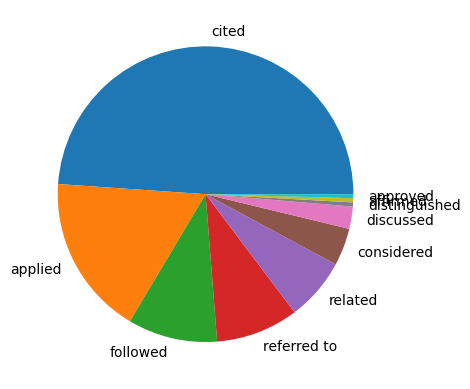

In [5]:
plt.pie(data.case_outcome.value_counts(),labels=data.case_outcome.unique())

По этой диаграмме можно увидеть, что классы несбалансированные

In [4]:
data.isna().sum() # выведу количество пропущенных значений, их суммарное количество для каждого столбца

case_id           0
case_outcome      0
case_title        0
case_text       176
dtype: int64

In [5]:
data = data.fillna('') #заполню NaN пустыми строками, чтобы в дальнейшем избежать ошибок при обработке

In [6]:
data.isna().sum() # сделала

case_id         0
case_outcome    0
case_title      0
case_text       0
dtype: int64

In [7]:
data['case_text_sum'] = pd.concat([data["case_title"], data["case_text"]], axis=1).apply(lambda x: ' '.join(x), axis=1) # соединю значение некоторых столбцов

In [8]:
fn = data['case_text_sum'].str.contains(r"https?://\S+|www\.\S+") # проверка содержит ли каждая строка то, что указано в регулярном выражении
res = data.loc[fn]

In [9]:
res.case_text[9] #  содержит ли строка URL-подобный текст или нет

'Hexal Australia Pty Ltd v Roche Therapeutics Inc (2005) 66 IPR 325, the likelihood of irreparable harm was regarded by Stone J as, indeed, a separate element that had to be established by an applicant for an interlocutory injunction. Her Honour cited the well-known passage from the judgment of Mason ACJ in Castlemaine Tooheys Ltd v South Australia [1986] HCA 58 ; (1986) 161 CLR 148 (at 153) as support for that proposition. Had it not been for the fact that there will be a speedy trial of this matter, which Stone J regarded as a relevant consideration in Hexal v Roche (at [78]), I might have been inclined to grant some, at least, of the orders sought by CSL. I will give the parties an opportunity to be heard in relation to the matter of costs. I certify that the preceding one hundred and seven (107) numbered paragraphs are a true copy of the Reasons for Judgment herein of the Honourable Justice Weinberg. Associate: Dated: 3 October 2006 Counsel for the Applicant: Mr B.N. Caine SC and D

In [11]:
#from sklearn.preprocessing import LabelEncoder

In [12]:
#le = LabelEncoder()
#data['case_outcome_num'] = le.fit_transform(data.case_outcome) # во-первых присвоится уникальные целочисленные значения, во-вторых, уменьшим размерность даных

Теперь нужно почистить текст. (Стоп-слова и пунктуация)

In [10]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ksyus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksyus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Почистим датасет и стандартизируем его для того, чтобы уменьшить большой набор данных

In [13]:
import string

In [14]:
data['case_text']=data['case_text'].astype('str')

In [15]:
# Для начала нужно написать функцию для того чтобы убрать пунктуацию
def remove_punctuation(text):
    punctuation="".join([i for i in text if i not in string.punctuation])
    return punctuation

In [16]:
# Теперь сохраню текст без знаков препинания
data['case_text']= data['case_text'].apply(lambda x:remove_punctuation(x))

In [17]:
# Еще нужно привести все к одному регистру, это уменьшит вероятность всяких ошибок
data['case_text']= data['case_text'].apply(lambda x: x.lower())
data['case_text']= data['case_text'].str.replace('\d+', '') #заменяя все вхождения одной или нескольких цифр подряд  строкой

In [18]:
stop = stopwords.words('english')

In [19]:
# Еще уберем стоп-слова
data['case_text']=data['case_text']
data['case_text'] = data['case_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [20]:
w = data.apply(lambda x:[i for i in x if i not in stop and len(i) > 2]) # если чего-то нет в списке стоп слов, то элемент добавляется, если длина слова больше двух, оно включается
w

case_id          [Case1, Case2, Case3, Case4, Case5, Case6, Cas...
case_outcome     [cited, cited, cited, cited, cited, cited, cit...
case_title       [Alpine Hardwood (Aust) Pty Ltd v Hardys Pty L...
case_text        [ordinarily discretion exercised costs follow ...
case_text_sum    [Alpine Hardwood (Aust) Pty Ltd v Hardys Pty L...
dtype: object

In [21]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ksyus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Теперь разделю выборку на трейн и на тест и обучу модель

In [22]:
print(set(data.case_outcome))

{'applied', 'considered', 'related', 'referred to', 'followed', 'cited', 'distinguished', 'approved', 'affirmed', 'discussed'}


In [23]:
data = data.dropna()

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   case_id        24985 non-null  object
 1   case_outcome   24985 non-null  object
 2   case_title     24985 non-null  object
 3   case_text      24985 non-null  object
 4   case_text_sum  24985 non-null  object
dtypes: object(5)
memory usage: 976.1+ KB


Так как данные несбалансированные, то попробую на class_weight
(Baseline)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(data.case_text, data.case_outcome, test_size=0.2)

In [41]:
vec = CountVectorizer(ngram_range=(1, 1)) #приписываю вектор
bow = vec.fit_transform(x_train)  

In [42]:
clf = LogisticRegression(solver='liblinear', random_state=42, max_iter=200, class_weight='balanced')
clf.fit(bow, y_train)

LogisticRegression(class_weight='balanced', max_iter=200, random_state=42,
                   solver='liblinear')

In [43]:
pred = clf.predict(vec.transform(x_test)) 
print(classification_report(pred, y_test))

               precision    recall  f1-score   support

     affirmed       0.52      0.30      0.38        54
      applied       0.31      0.30      0.30       500
     approved       0.14      0.14      0.14        28
        cited       0.67      0.69      0.68      2347
   considered       0.34      0.34      0.34       354
    discussed       0.36      0.31      0.33       244
distinguished       0.47      0.37      0.41       147
     followed       0.36      0.37      0.36       439
  referred to       0.50      0.51      0.50       870
      related       0.31      0.36      0.33        14

     accuracy                           0.53      4997
    macro avg       0.40      0.37      0.38      4997
 weighted avg       0.53      0.53      0.53      4997



Точность на class-weight примерно равна 53% precision, recall, f1-score отклоняются внутри немного.

Теперь попробую на TF-IDF, но перед началом почишу данные по-другому

In [44]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [45]:
noise = stopwords.words('english') + list(punctuation)

In [46]:
# Попробую обучить с униграммами
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)

In [47]:
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

               precision    recall  f1-score   support

     affirmed       0.35      0.65      0.46        17
      applied       0.24      0.33      0.27       348
     approved       0.14      0.36      0.21        11
        cited       0.82      0.64      0.72      3093
   considered       0.21      0.39      0.27       195
    discussed       0.22      0.42      0.29       110
distinguished       0.28      0.51      0.36        65
     followed       0.26      0.41      0.32       283
  referred to       0.49      0.49      0.49       867
      related       0.38      0.75      0.50         8

     accuracy                           0.57      4997
    macro avg       0.34      0.50      0.39      4997
 weighted avg       0.64      0.57      0.59      4997



Точность стала немного выше, примерно 57%, precision, recall, f1-score тоже улучшились.
Теперь выгружу все заново.

In [2]:
data = pd.read_csv('legal_text_classification.csv')
data.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24985 non-null  object
 1   case_outcome  24985 non-null  object
 2   case_title    24985 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 780.9+ KB


In [4]:
data.case_outcome.unique()

array(['cited', 'applied', 'followed', 'referred to', 'related',
       'considered', 'discussed', 'distinguished', 'affirmed', 'approved'],
      dtype=object)

In [5]:
data.case_outcome.value_counts()

case_outcome
cited            12219
referred to       4384
applied           2448
followed          2256
considered        1712
discussed         1024
distinguished      608
related            113
affirmed           113
approved           108
Name: count, dtype: int64

In [6]:
data = data.fillna('')

In [7]:
data = data.drop('case_id', axis=1)

In [8]:
data['case_text_sum'] = data["case_title"] + data["case_text"] # соединю между собой case_title и case_text

In [9]:
data.head()

,case_outcome,case_title,case_text,case_text_sum
0,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...
1,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...
2,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...
3,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...
4,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...,Dr Martens Australia Pty Ltd v Figgins Holding...


In [10]:
data = data.drop(['case_text', 'case_title'], axis=1)

In [12]:
data.head().copy()

,case_outcome,case_text_sum
0,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...
1,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...
2,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...
3,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...
4,cited,Dr Martens Australia Pty Ltd v Figgins Holding...


In [13]:
# Переведу в число переменную case_outcome
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['case_outcome_numeric'] = le.fit_transform(data['case_outcome'])

In [14]:
data.head()

,case_outcome,case_text_sum,case_outcome_numeric
0,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,3
1,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,3
2,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,3
3,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,3
4,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,3


In [15]:
# удалю case_outcome
data = data.drop('case_outcome', axis=1)

In [16]:
data.head()

,case_text_sum,case_outcome_numeric
0,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,3
1,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,3
2,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,3
3,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,3
4,Dr Martens Australia Pty Ltd v Figgins Holding...,3


Теперь почишу то, что находится в тексте

In [17]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

In [18]:
# Немного почишу опять:
print(stopwords.words('english'))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
import nltk
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksyus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
def hello(text): # Функция для лемматизации и удаления стоп слов
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.lower() # приведу все к нижнему регистру
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text) # токенизирую
    tokens = [word for word in tokens if word not in stopwords]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens) # возвращает текст

In [27]:
# Нужно немного стандартизировать модель и прогнать через Pipeline, чтобы немного уменьшить объем данных
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
# Создаем Pipeline с TfidfVectorizer и SelectKBest
pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()), # преобразую текстовых данных в числовые векторы с весами TF-IDF
    ('chi2', SelectKBest(chi2, k=1000)), # выберу 1000 лучших признаков с помощью SelectKBest
    ('lr', LogisticRegression())
], verbose=True)

In [29]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk import ngrams
from sklearn.metrics import accuracy_score

In [52]:
x = data['case_text_sum']  
y = data['case_outcome_numeric']  

In [53]:
x_train, x_test, y_train, y_test = train_test_split(data.case_text_sum, data.case_outcome_numeric, test_size=0.2)

In [54]:
# Обучу модель и оценю точность
pipe.fit(x_train, y_train)  # на обучающих данных

[Pipeline] ............. (step 1 of 3) Processing tfidf, total=   8.3s
[Pipeline] .............. (step 2 of 3) Processing chi2, total=   0.2s
[Pipeline] ................ (step 3 of 3) Processing lr, total=   1.1s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('chi2',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x0000026E6B40AF70>)),
                ('lr', LogisticRegression())],
         verbose=True)

In [55]:
# Предсказание (тестовый набор)
y_pred = pipe.predict(x_test)

In [56]:
# Оценка точности
accuracy = pipe.score(x_test, y_test)

In [57]:
print("Accuracy:", accuracy)

Accuracy: 0.4890934560736442


Ну, кажется стало хуже 49%... Нагляднее выведу через classification_report

In [58]:
from sklearn.metrics import classification_report
# Оценка точности модели с помощью classification report
y_pred = pipe.predict(x_test)  # Получение предсказаний модели на тестовом наборе данных
report = classification_report(y_test, y_pred)  # Генерация отчета classification report

In [59]:
# Вывод отчета classification report на экран
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.15      0.26        26
           1       0.00      0.00      0.00       501
           2       0.00      0.00      0.00        19
           3       0.49      0.99      0.65      2412
           4       0.33      0.00      0.01       361
           5       1.00      0.01      0.01       189
           6       0.00      0.00      0.00       121
           7       0.50      0.01      0.02       467
           8       0.51      0.06      0.11       876
           9       0.00      0.00      0.00        25

    accuracy                           0.49      4997
   macro avg       0.36      0.12      0.11      4997
weighted avg       0.44      0.49      0.34      4997



Примерно, 49%, но показатели внутри стали хуже, очень сильный дисбаланс внутри f1-score, recall, precision.
Общий вывод: я пыталась показать на несбалансированных классах, изменив random state, но не очень помогло, так как память на диске C полностью забилась, пришлось почистить. В итоге я решила не включать это в решение.
Из двух модель лучше всего получилась самая первая. Результат составил 57%, дальше результат был хуже 49%